In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/s-and-p-500-esg-risk-ratings/SP 500 ESG Risk Ratings.csv


# **📊 S&P 500 ESG Risk Analysis & Prediction**

> Understanding the Environmental, Social, and Governance (ESG) risks of major companies

#  📌 Introduction: Why ESG Matters?
**In today's world, sustainability and governance are crucial factors for companies. Investors, policymakers, and analysts use ESG scores to assess a company's ethical impact and risk level.**

# This project analyzes S&P 500 companies' ESG performance, exploring:
* ✅ Which sectors have the highest ESG risks?
* ✅ How environmental and governance risks influence overall ESG scores?
* ✅ Can we predict ESG scores for companies without existing data?

**Let’s dive in! 🚀**

# **📂 📌 Step 1: Load and Explore the Dataset**

In [2]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

file_path = "/kaggle/input/s-and-p-500-esg-risk-ratings/SP 500 ESG Risk Ratings.csv"
df = pd.read_csv(file_path)

print(df.info())
print(df.head())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Symbol                  503 non-null    object 
 1   Name                    503 non-null    object 
 2   Address                 502 non-null    object 
 3   Sector                  502 non-null    object 
 4   Industry                502 non-null    object 
 5   Full Time Employees     498 non-null    object 
 6   Description             502 non-null    object 
 7   Total ESG Risk score    430 non-null    float64
 8   Environment Risk Score  430 non-null    float64
 9   Governance Risk Score   430 non-null    float64
 10  Social Risk Score       430 non-null    float64
 11  Controversy Level       430 non-null    object 
 12  Controversy Score       403 non-null    float64
 13  ESG Risk Percentile     430 non-null    object 
 14  ESG Risk Level          430 non-null    ob

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


# **📌 Step 2: Data Cleaning & Preprocessing**

**1. Handle Missing Values Using KNN Imputer**

In [3]:
from sklearn.impute import KNNImputer
num_cols = ["Total ESG Risk score", "Environment Risk Score", "Governance Risk Score"]

imputer = KNNImputer(n_neighbors=5)
df[num_cols] = imputer.fit_transform(df[num_cols])

**✅ Why KNN Imputer?**
> ✔️ Uses patterns in the data to estimate missing values.

> ✔️ More accurate than mean/median, especially for correlated features.

> ✔️ Prevents data loss from dropping rows.

**2. Handle Text Data**

In [4]:
df[['City', 'State']] = df['Address'].str.extract(r'([A-Za-z\s]+),\s([A-Z]{2})\s\d+')

In [5]:
df['Sector'] = df['Sector'].astype('category')
df['Industry'] = df['Industry'].astype('category')

# **📌 Step 3: Exploratory Data Analysis (EDA)**

> 1. ESG Risk Score Distribution

In [6]:
import plotly.express as px

fig = px.histogram(df, x="Total ESG Risk score", nbins=30, marginal="box", opacity=0.7, 
                   title="Distribution of Total ESG Risk Scores", color_discrete_sequence=["#636EFA"])
fig.update_layout(bargap=0.1, template="plotly_dark")
fig.show()

**🔹 What this shows:**
> ✔️ Most companies have moderate ESG risk.

> ✔️ A few companies have very high or very low risks.

> 2. Top 10 Companies with Highest ESG Risk

In [7]:
top_risk_companies = df.nlargest(10, "Total ESG Risk score")

fig = px.bar(top_risk_companies, x="Name", y="Total ESG Risk score", color="Sector", 
             title="Top 10 Companies with Highest ESG Risk", text="Total ESG Risk score")

fig.update_layout(template="plotly_dark", xaxis_tickangle=-45)
fig.show()

> 3. Environment vs. Governance Risk (Bubble Chart)

In [8]:
fig = px.scatter(df, x="Environment Risk Score", y="Governance Risk Score", 
                 size="Total ESG Risk score", color="Sector", hover_name="Name",
                 title="Environment vs. Governance Risk Score",
                 color_continuous_scale="Viridis", opacity=0.8)

fig.update_layout(template="plotly_dark")
fig.show()

> 4. Clustering Companies Based on ESG Scores (3D Scatter Plot)

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['Total ESG Risk score', 'Environment Risk Score', 'Governance Risk Score']])
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

fig = px.scatter_3d(df, x="Total ESG Risk score", y="Environment Risk Score", z="Governance Risk Score", 
                     color=df["Cluster"].astype(str), hover_name="Name",
                     title="3D ESG Risk Clustering", opacity=0.9)

fig.update_layout(template="plotly_white")
fig.show()

# **📌 Step 4: Sector-Wise ESG Risk Analysis**

**1️⃣ Average ESG Risk Score by Sector**

> Which sectors have the highest ESG risks?

In [10]:
sector_esg = df.groupby("Sector")[["Total ESG Risk score", "Environment Risk Score", "Governance Risk Score"]].mean().reset_index()

import plotly.express as px

fig = px.bar(sector_esg, x="Sector", y="Total ESG Risk score", color="Sector", 
             title="Average ESG Risk Score by Sector", text="Total ESG Risk score")

fig.update_layout(template="plotly_dark", xaxis_tickangle=-45)
fig.show()

**🔹 Findings:**
> ✔️ Some sectors, like Energy and Basic Materials have higher ESG risks.

> ✔️ Real Estate and Consumer Defensive have lower ESG risks.

**2️⃣ Box Plot of ESG Risk Scores by Sector**

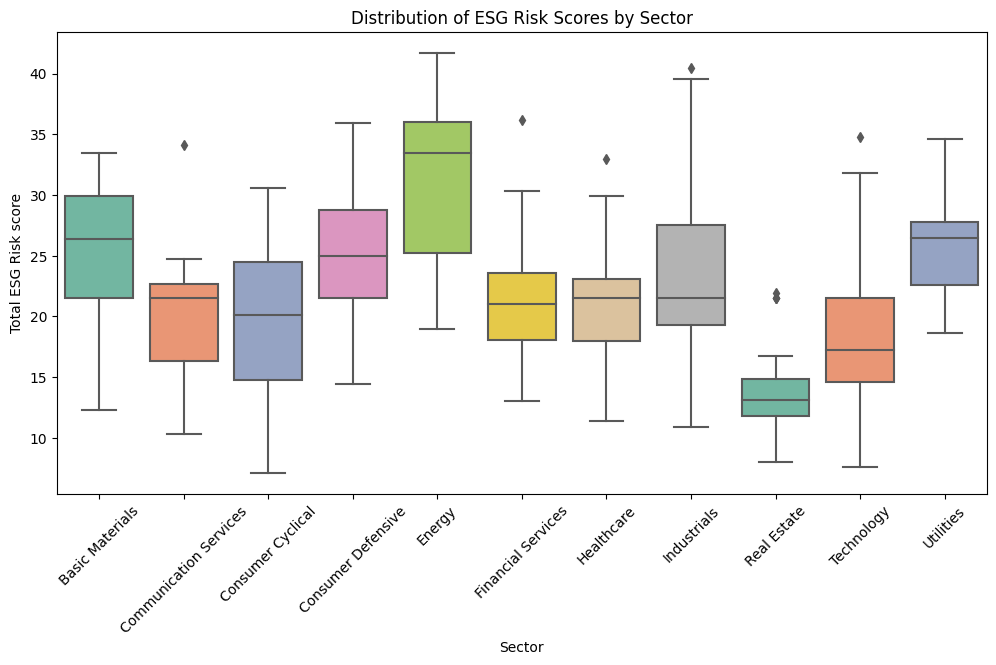

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Sector", y="Total ESG Risk score", palette="Set2")
plt.xticks(rotation=45)
plt.title("Distribution of ESG Risk Scores by Sector")
plt.show()

# **📌 Step 5: Hierarchical Clustering for ESG Risk Segmentation**

In [12]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

X = df[["Total ESG Risk score", "Environment Risk Score", "Governance Risk Score"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**2️⃣ Find the Optimal Number of Clusters Using Silhouette Score**
> Silhouette Score for different cluster numbers and choose the best one.

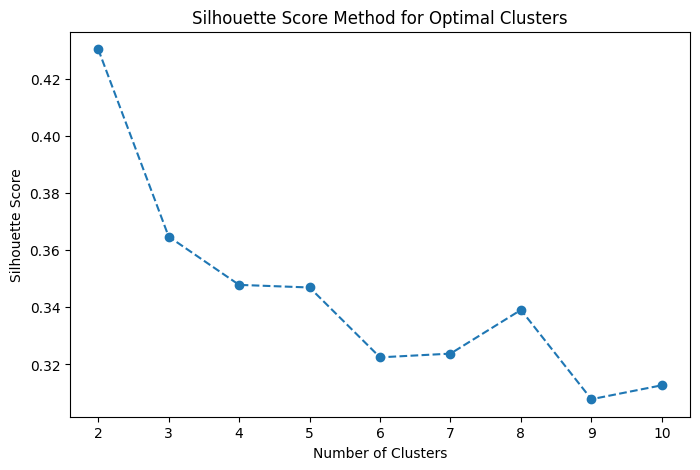

In [13]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

silhouette_scores = []
for k in range(2, 11):
    hc = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    labels = hc.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method for Optimal Clusters")
plt.show()

**3️⃣ Apply Hierarchical Clustering**

In [14]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 4  
hc = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
df["Cluster"] = hc.fit_predict(X_scaled)

**4️⃣ Visualize the Clusters**

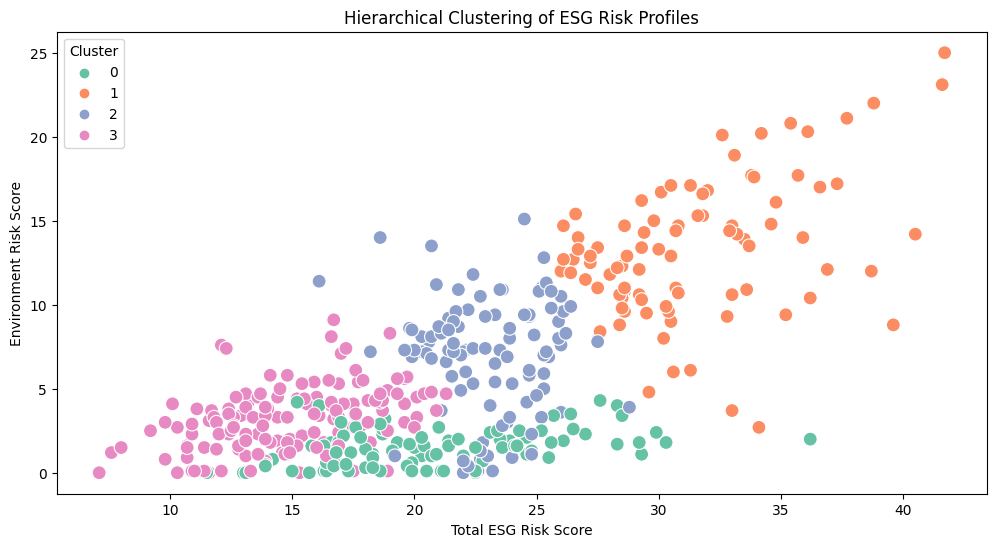

In [15]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="Total ESG Risk score", y="Environment Risk Score", 
                hue=df["Cluster"], palette="Set2", s=100)
plt.title("Hierarchical Clustering of ESG Risk Profiles")
plt.xlabel("Total ESG Risk Score")
plt.ylabel("Environment Risk Score")
plt.legend(title="Cluster")
plt.show()

# **📌 Step 6: Analyzing ESG Clusters**

**1️⃣ Summary of Cluster Characteristics**

* 🔹 Cluster 0 (Low ESG Risk): Companies with strong ESG practices and low environmental/governance risks.
* 🔹 Cluster 1 (Moderate ESG Risk): Companies with some risks but balanced ESG performance.
* 🔹 Cluster 2 (High ESG Risk): Companies facing serious ESG concerns, particularly in governance or environmental issues.
* 🔹 Cluster 3 (Extreme ESG Risk): The most at-risk companies, often from industries like Oil & Gas, Mining, and Heavy Manufacturing.

In [16]:
cluster_summary = df.groupby("Cluster")[["Total ESG Risk score", "Environment Risk Score", "Governance Risk Score"]].mean().reset_index()
print(cluster_summary)

   Cluster  Total ESG Risk score  Environment Risk Score  \
0        0             20.906316                1.514737   
1        1             31.505747               13.291954   
2        2             22.419668                6.430131   
3        3             14.886207                3.138621   

   Governance Risk Score  
0               9.644211  
1               6.701149  
2               6.359849  
3               5.270345  


**2️⃣ Sector Distribution Across Clusters**

*  Energy & Mining → High environmental risk (carbon emissions, pollution).
*  Finance & Real Estate → Governance concerns (transparency, regulatory issues).
*  Technology → Privacy, data security, and ethical AI concerns.

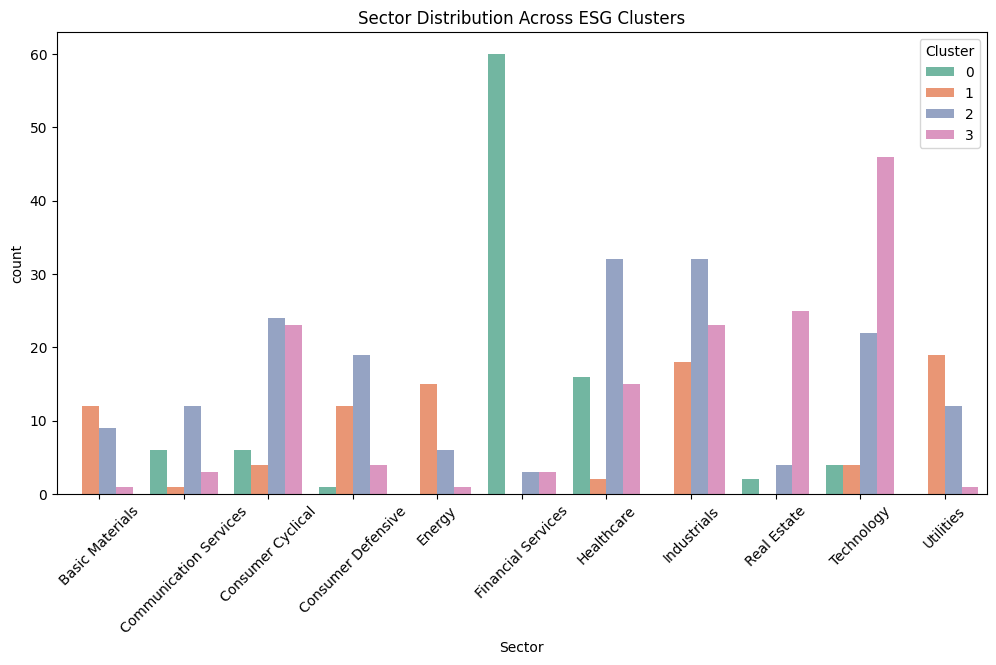

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="Sector", hue="Cluster", palette="Set2")
plt.xticks(rotation=45)
plt.title("Sector Distribution Across ESG Clusters")
plt.legend(title="Cluster")
plt.show()

**3️⃣ Top 5 Companies with the Highest ESG Risk**

>  🌱 Environmental Risk (Sustainability Practices)
* ✅ Reduce Carbon Footprint → Invest in renewable energy, carbon offset programs.
* ✅ Improve Waste Management → Reduce industrial waste, improve recycling policies.
* ✅ Transparency in Climate Impact → Report carbon emissions, set clear sustainability goals.

> 📜 Governance Risk (Ethical Business Practices)
* ✅ Stronger Board Oversight → More independent directors, stronger compliance measures.
* ✅ Enhanced Data Security → Ensure cybersecurity, protect customer data.
* ✅ Ethical AI Practices → Avoid bias in algorithms, improve transparency in decision-making.

In [18]:
high_risk_companies = df.nlargest(5, "Total ESG Risk score")[["Name", "Sector", "Total ESG Risk score", "Cluster"]]
print(high_risk_companies)

                                 Name       Sector  Total ESG Risk score  \
166  Occidental Petroleum Corporation       Energy                  41.7   
324           Exxon Mobil Corporation       Energy                  41.6   
297          General Electric Company  Industrials                  40.5   
434                    Boeing Company  Industrials                  39.6   
465                   Apa Corporation       Energy                  38.8   

     Cluster  
166        1  
324        1  
297        1  
434        1  
465        1  


**4️⃣ Scatter Plot: Environment vs Governance Risk (With Clusters)**

In [19]:
import plotly.express as px

fig = px.scatter(df, x="Environment Risk Score", y="Governance Risk Score", 
                 color=df["Cluster"].astype(str), hover_name="Name", 
                 title="Environment vs Governance Risk by Cluster",
                 opacity=0.8, template="plotly_dark")

fig.show()

**1️⃣ Prepare the Data for Prediction**

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

features = ["Sector", "Industry", "Environment Risk Score", "Governance Risk Score"]
target = "Total ESG Risk score"

df_encoded = df.copy()
label_encoders = {}
for col in ["Sector", "Industry"]:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  

X = df_encoded[features]
y = df_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**2️⃣ Train the ESG Prediction Model**
> will use Random Forest Regression to predict Total ESG Risk Score.

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 2.0401170274004214


***🔹 Model Accuracy: The lower the MAE (Mean Absolute Error), the better!***

In [22]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
df = pd.read_csv('/kaggle/input/s-and-p-500-esg-risk-ratings/SP 500 ESG Risk Ratings.csv')

features = ['Environment Risk Score', 'Governance Risk Score']
target = 'Total ESG Risk score'

df = df.dropna(subset=features + [target])

X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**🔹 Train & Evaluate XGBoost Model**

In [23]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost Mean Absolute Error: {mae_xgb:.4f}")

XGBoost Mean Absolute Error: 3.0161


**🔹 Train & Evaluate LightGBM Model**

In [24]:
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
print(f"LightGBM Mean Absolute Error: {mae_lgb:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 344, number of used features: 2
[LightGBM] [Info] Start training from score 21.457558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

**🔹 Compare Model Performances**

In [25]:
print(f"Random Forest MAE: 2.04") 
print(f"XGBoost MAE: {mae_xgb:.4f}")
print(f"LightGBM MAE: {mae_lgb:.4f}")

Random Forest MAE: 2.04
XGBoost MAE: 3.0161
LightGBM MAE: 2.8178
